In [11]:
from optimizers import *
from opt_utils_v1a import *

# Optimization Methods


## 1 - Gradient Descent
### Update_parameters_with_gd
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

## 2 - Mini-Batch Gradient Descent

#### 🔀 Step 1: Shuffle the Data
The first step randomly shuffles the training examples, which is already provided. This ensures that each mini-batch contains different types of examples and helps reduce variance in training.

#### 📦 Step 2: Partition into Mini-Batches
We then use a loop to create mini-batches of size `mini_batch_size = 64`. We do this by slicing the shuffled data as follows:

```python
mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
```

This uses `k` to move in steps of 64 along the columns of the input matrix.

#### 🧮 Step 3: Handle the Last Mini-Batch
If the total number of examples `m` isn’t divisible by 64, the last mini-batch will contain fewer than 64 examples. We calculate its starting index and slice until the end:

```python
start = num_complete_minibatches * mini_batch_size
mini_batch_X = shuffled_X[:, start : m]
```

### ⚙️ 3 - Momentum

Momentum helps accelerate gradient descent by accumulating an exponentially weighted average of past gradients.

Update rule:

```
v_dW[l] = β * v_dW[l] + (1 - β) * dW[l]  
W[l] = W[l] - α * v_dW[l]
```

---

### ⚙️ 4 - RMSprop

RMSprop adapts the learning rate for each parameter by dividing by the root of the exponentially weighted average of the squared gradients.

Update rule:

```
s_dW[l] = β * s_dW[l] + (1 - β) * (dW[l])²  
W[l] = W[l] - α * dW[l] / (sqrt(s_dW[l]) + ε)
```

---

### ⚙️ 5 - Adam (Adaptive Moment Estimation)

Adam combines **Momentum** and **RMSprop**, using both the first and second moment estimates of the gradients.

Update rules:

```
v_dW[l] = β₁ * v_dW[l] + (1 - β₁) * dW[l]  
s_dW[l] = β₂ * s_dW[l] + (1 - β₂) * (dW[l])²  

v_corrected = v_dW[l] / (1 - β₁ᵗ)  
s_corrected = s_dW[l] / (1 - β₂ᵗ)  

W[l] = W[l] - α * v_corrected / (sqrt(s_corrected) + ε)
```

With:
- `β₁ ≈ 0.9`, `β₂ ≈ 0.999`, `ε ≈ 1e-8`
- `t` is the current iteration


```math
\textbf{Momentum:}
\begin{aligned}
v_{dW^{[l]}} &= \beta v_{dW^{[l]}} + (1 - \beta) \cdot dW^{[l]} \\
W^{[l]} &= W^{[l]} - \alpha \cdot v_{dW^{[l]}}
\end{aligned}
```

```math
\textbf{RMSprop:}
\begin{aligned}
s_{dW^{[l]}} &= \beta s_{dW^{[l]}} + (1 - \beta) \cdot (dW^{[l]})^2 \\
W^{[l]} &= W^{[l]} - \alpha \cdot \frac{dW^{[l]}}{\sqrt{s_{dW^{[l]}} + \varepsilon}}
\end{aligned}
```

```math
\textbf{Adam (Adaptive Moment Estimation):}
\begin{aligned}
v_{dW^{[l]}} &= \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \cdot dW^{[l]} \\
s_{dW^{[l]}} &= \beta_2 s_{dW^{[l]}} + (1 - \beta_2) \cdot (dW^{[l]})^2 \\
\hat{v}_{dW^{[l]}} &= \frac{v_{dW^{[l]}}}{1 - \beta_1^t}, \quad 
\hat{s}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - \beta_2^t} \\
W^{[l]} &= W^{[l]} - \alpha \cdot \frac{\hat{v}_{dW^{[l]}}}{\sqrt{\hat{s}_{dW^{[l]}}} + \varepsilon}
\end{aligned}
```


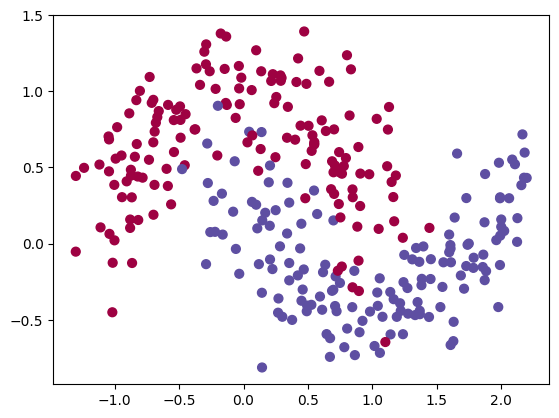

In [12]:
train_X, train_Y = load_dataset()

In [13]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [15]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p


## 1. Mini-Batch Gradient Descent

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367


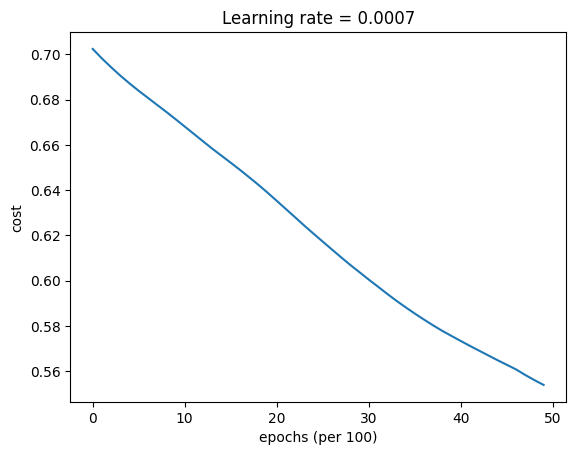

Accuracy: 0.7166666666666667


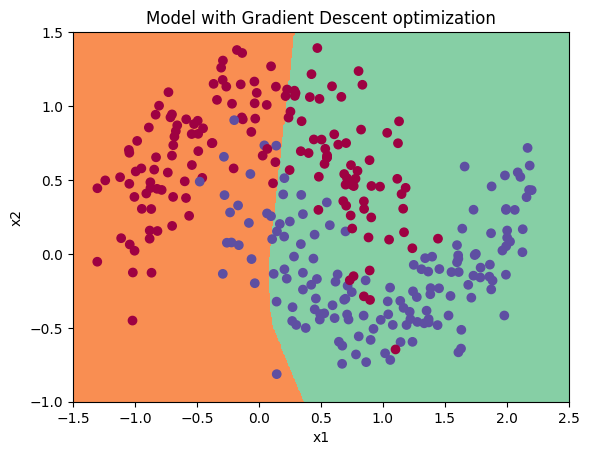

In [16]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 2.Mini-Batch Gradient Descent with Momentum


Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444


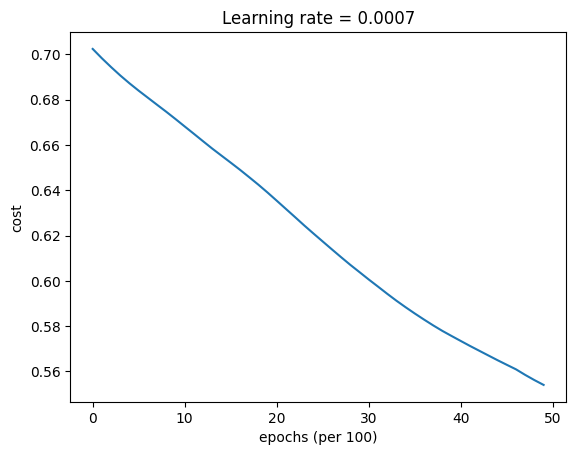

Accuracy: 0.7166666666666667


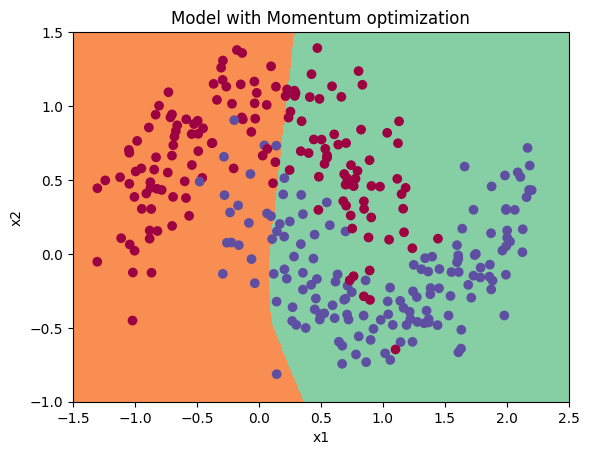

In [17]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 3.Mini-Batch with Adam

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066


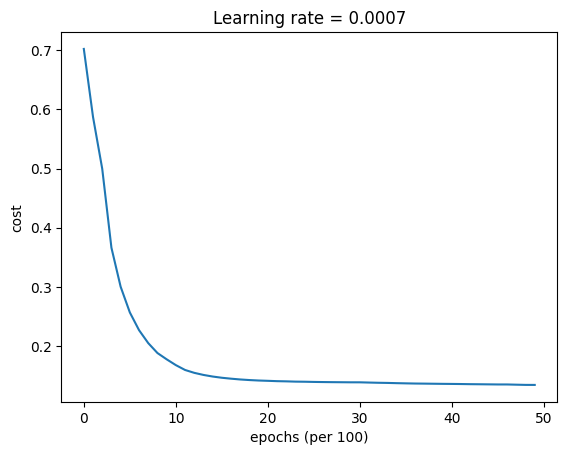

Accuracy: 0.9433333333333334


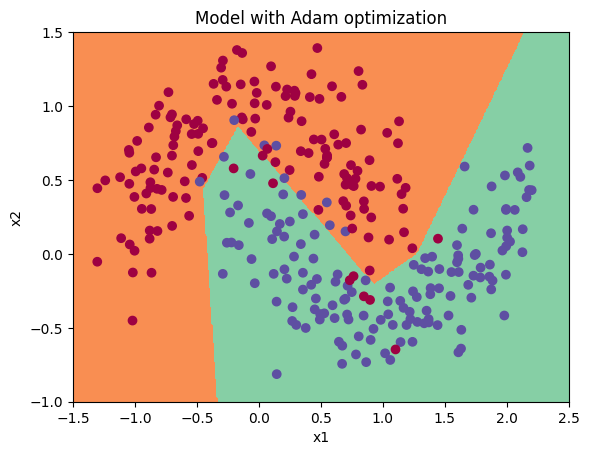

In [18]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 4. Learning Rate Decay and Scheduling

In [19]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### 4.1 - Decay on every iteration  


$$\alpha = \frac{1}{1 + decayRate \times epochNumber} \alpha_{0}$$


In [20]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    learning_rate =learning_rate0/(1 + decay_rate * epoch_num) 
    
    
    return learning_rate

In [22]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)
epoch_num = 2
decay_rate = 1
learning_rate_2 = update_lr(learning_rate, epoch_num, decay_rate)

print("Updated learning rate: ", learning_rate_2)



Original learning rate:  0.5
Updated learning rate:  0.16666666666666666


Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.661884
learning rate after epoch 1000: 0.000100
Cost after epoch 2000: 0.658620
learning rate after epoch 2000: 0.000050
Cost after epoch 3000: 0.656765
learning rate after epoch 3000: 0.000033
Cost after epoch 4000: 0.655486
learning rate after epoch 4000: 0.000025


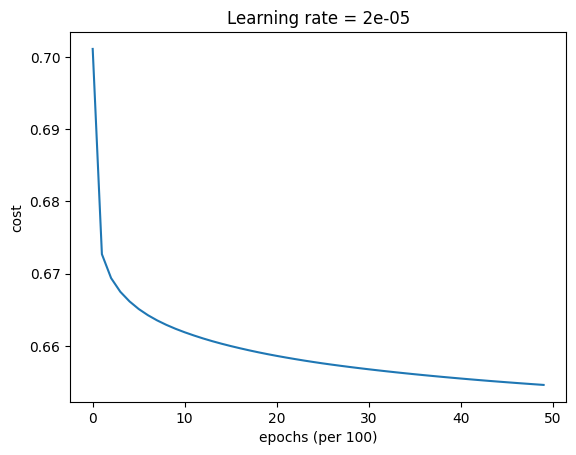

Accuracy: 0.6533333333333333


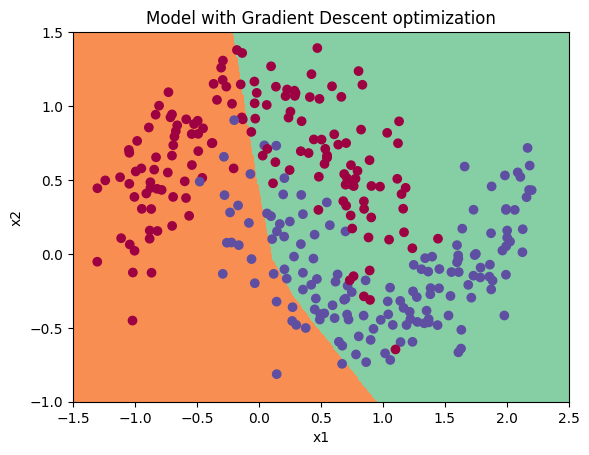

In [23]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 4.2 - Fixed Interval Scheduling

$$\alpha = \frac{1}{1 + decayRate \times \lfloor\frac{epochNum}{timeInterval}\rfloor} \alpha_{0}$$


In [24]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    learning_rate = learning_rate0 / (1 + decay_rate * np.floor(epoch_num  / time_interval))
    return learning_rate

In [25]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)

epoch_num_1 = 10
epoch_num_2 = 100
decay_rate = 0.3
time_interval = 100
learning_rate_1 = schedule_lr_decay(learning_rate, epoch_num_1, decay_rate, time_interval)
learning_rate_2 = schedule_lr_decay(learning_rate, epoch_num_2, decay_rate, time_interval)
print("Updated learning rate after {} epochs: ".format(epoch_num_1), learning_rate_1)
print("Updated learning rate after {} epochs: ".format(epoch_num_2), learning_rate_2)



Original learning rate:  0.5
Updated learning rate after 10 epochs:  0.5
Updated learning rate after 100 epochs:  0.3846153846153846


Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.127161
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.120304
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.117033
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.117512
learning rate after epoch 4000: 0.020000


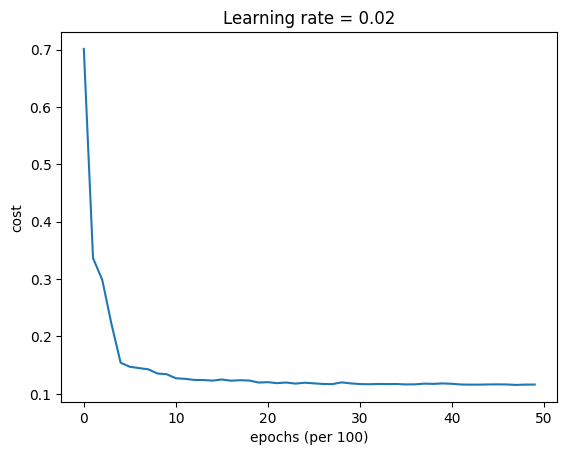

Accuracy: 0.9433333333333334


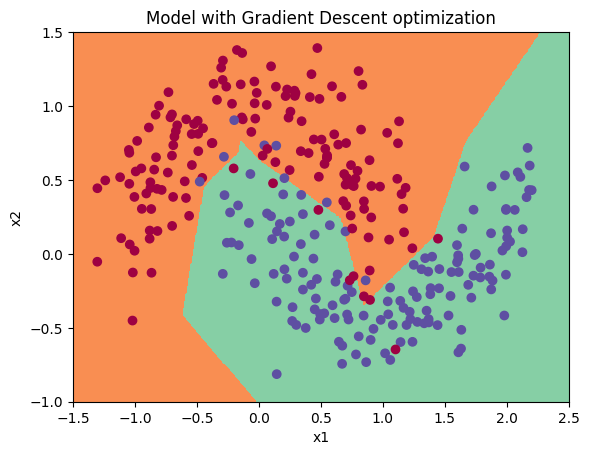

In [26]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.669865
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.148370
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.150075
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.147160
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.141404
learning rate after epoch 4000: 0.020000


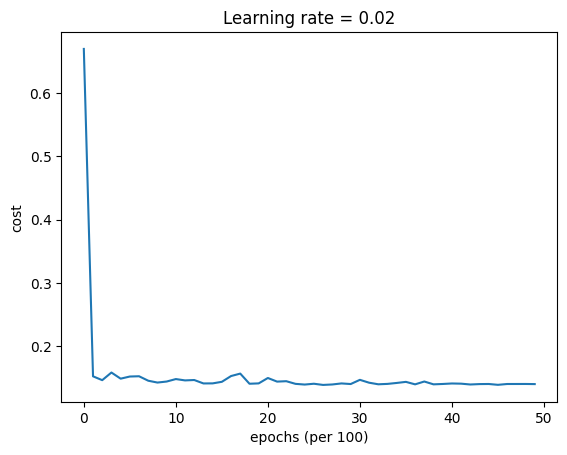

Accuracy: 0.9366666666666666


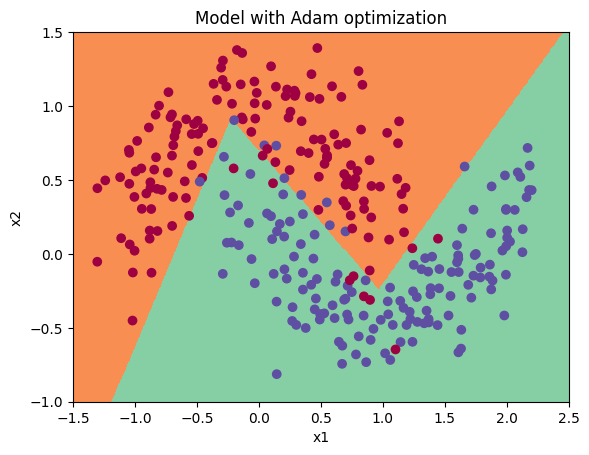

In [27]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 5. Achieving similar performance with different methods

<table> 
    <tr>
        <td>
        <b>optimization method</b>
        </td>
        <td>
        <b>accuracy</b>
        </td>
    </tr>
        <td>
        Gradient descent
        </td>
        <td>
        >94.6%
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        >95.6%
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        94%
        </td>
    </tr>
</table> 